In [1]:
import deepxde as dde
import numpy as np

Using backend: tensorflow

2023-01-16 02:02:34.832383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 02:02:36.908708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 02:02:36.941788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 02:02:36.942198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

Enable just-in-time compilation with XLA.



In [2]:
dde.config.set_random_seed(2137)

In [3]:
L = 5
m = 1
omega = 0.5

In [4]:
n = 2

In [5]:
domain = dde.geometry.Interval(-L, L)

In [6]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    E = (n + 0.5) * omega
    U = 0.5 * m * (omega ** 2) * (x ** 2)
    return -dy_xx / 2 + (U - E) * y

In [7]:
def psi(x):
    constants = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    exponent = np.exp(-0.5 * m * omega * np.power(x, 2))
    hermite_coefficients = [0] * n + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(x * np.sqrt(m * omega))
    result = constants * exponent * hermite_value
    return result.astype(dde.config.real(np))

a = np.linspace(0,1,100000)
dx = a[1] - a[0]
dpsi = psi(a[1]) - psi(a[0])

In [8]:
psi_0, dpsi_0 = (psi(0), dpsi / dx)

In [9]:
def boundary(x, on_boundary):
    return np.isclose(x[0], 0)

def boundary_value(x):
    return psi_0

def boundary_derivative_value(x):
    return dpsi_0

In [10]:
dirichlet_bc = dde.icbc.DirichletBC(domain, boundary_value, boundary)
neumann_bc = dde.icbc.NeumannBC(domain, boundary_derivative_value, boundary)

bcs = [dirichlet_bc, neumann_bc]

In [11]:
data = dde.data.PDE(domain, pde, bcs, 16, 2, solution=psi, num_test=100)

In [12]:
layer_size = [1] + [20] * 5 + [1]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN(layer_size, activation, initializer)

2023-01-16 02:02:45.909614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 02:02:45.910816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 02:02:45.912166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 02:02:45.913367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [13]:
model = dde.Model(data, net)
model.compile('L-BFGS', metrics=['l2 relative error'])

Compiling model...
'compile' took 0.020506 s



In [14]:
loss_history, train_state = model.train(iterations=10000)

Training model...



/home/piotr/repos/quant-chem-pinns/venv/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-16 02:02:51.461588: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1c889720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-16 02:02:51.461617: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-01-16 02:02:51.474238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-16 02:02:52.680944: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                        Test loss                         Test metric   
0         [9.00e-01, 1.99e-01, 0.00e+00]    [5.13e-01, 1.99e-01, 0.00e+00]    [2.75e+00]    
1000      [2.31e-04, 1.02e-06, 0.00e+00]    [1.86e-04, 1.02e-06, 0.00e+00]    [2.00e-02]    
2000      [6.74e-05, 1.71e-08, 0.00e+00]    [8.55e-05, 1.71e-08, 0.00e+00]    [6.73e-03]    
3000      [2.51e-05, 4.51e-09, 0.00e+00]    [1.17e-04, 4.51e-09, 0.00e+00]    [6.66e-03]    
4000      [1.34e-05, 2.07e-09, 0.00e+00]    [1.81e-04, 2.07e-09, 0.00e+00]    [7.13e-03]    
5000      [9.54e-06, 1.61e-09, 0.00e+00]    [1.79e-04, 1.61e-09, 0.00e+00]    [6.71e-03]    
6000      [6.63e-06, 2.20e-09, 0.00e+00]    [1.53e-04, 2.20e-09, 0.00e+00]    [5.94e-03]    
7000      [4.80e-06, 9.13e-10, 0.00e+00]    [1.29e-04, 9.13e-10, 0.00e+00]    [5.34e-03]    
8000      [1.31e-05, 3.39e-07, 0.00e+00]    [1.14e-04, 3.39e-07, 0.00e+00]    [1.13e-02]    
9000      [3.00e-06, 4.80e-08, 0.00e+00]    [9.63e-05, 4.80e-08, 0.00e

Saving loss history to /home/piotr/repos/quant-chem-pinns/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/test.dat ...


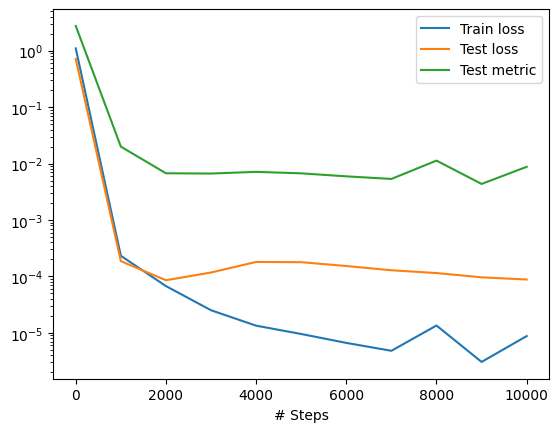

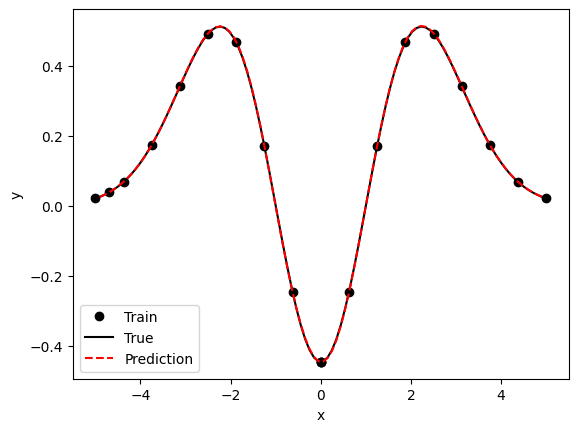

In [15]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [ ]:
psi(0)

In [ ]:
(psi(0.1) - psi(-0.1)) / 0.2